Demo: Logistic regression for classification of handwritten digits
==================================================================

*Fraida Fund*

In this demo, we will explore the use of logistic regression for classification of handwritten digits. In other words, given an image of a handwritten digit, we want to classify it as a 0, 1, 2, 3, ...

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Load the digits dataset

For this demo, we will use a dataset known as [MNIST](https://en.wikipedia.org/wiki/MNIST_database). It contains 70,000 samples of handwritten digits, size-normalized and centered in a fixed-size image. Each sample is represented as a 28x28 pixel array, so there are 784 features per samples.

We will start by loading the dataset using the `fetch_openml` function. This function allows us to retrieve a dataset by name from [OpenML](https://www.openml.org/), a public repository for machine learning data and experiments.

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

We observe that the data has 784 features and we have 70,000 samples:

In [ ]:
X.shape

(70000, 784)

The target variables is a label for each digit: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. There are 6000-8000 samples for each class.

In [ ]:
y.shape

(70000,)

In [ ]:
print(y)

['5' '0' '4' ... '4' '5' '6']


In [ ]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

In [ ]:
classes = ['0', '1', '2','3', '4','5', '6', '7', '8', '9']
nclasses = len(classes)

Each “feature” represents a pixel in the image, and each pixel can take on any integer value from 0 to 255. A large value for a pixel means that there is writing in that part of the image.

We can see a few examples, by plotting the 784 features as a 28x28 grid. In these images, white pixels indicate high values in the feature matrix.

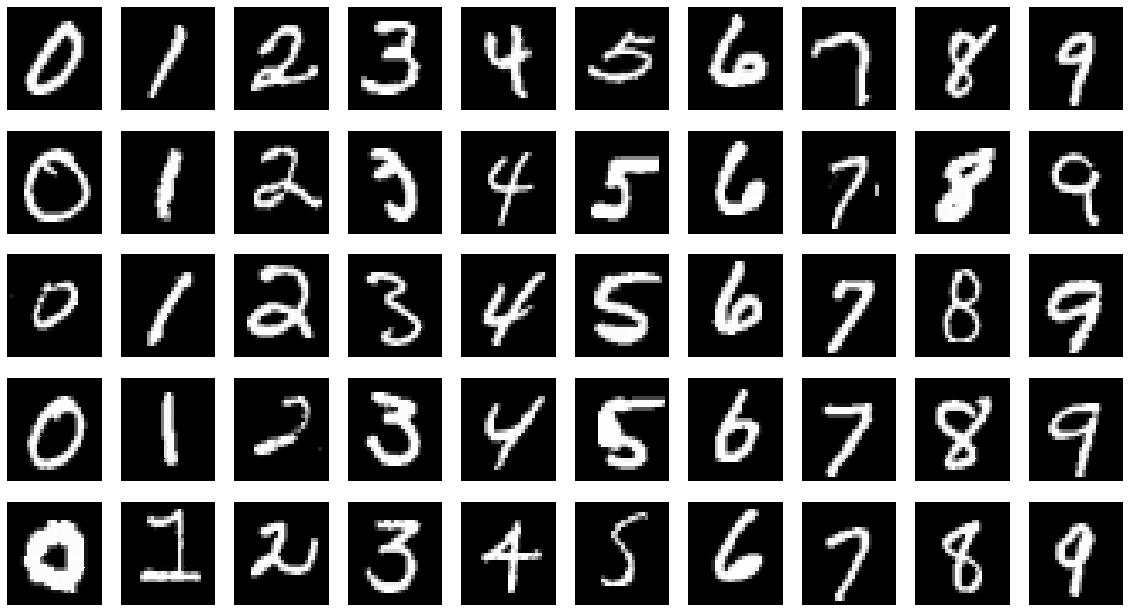

In [ ]:
samples_per_class = 5
figure = plt.figure(figsize=(nclasses*2,(1+samples_per_class*2)));

for idx_cls, cls in enumerate(classes):
  idxs = np.flatnonzero(y == cls)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * nclasses + idx_cls + 1
    p = plt.subplot(samples_per_class, nclasses, plt_idx);
    p = sns.heatmap(np.reshape(X[idx], (28,28)), cmap=plt.cm.gray, 
             xticklabels=False, yticklabels=False, cbar=False);
    p = plt.axis('off');

### Prepare data

Next, we will split our data into a test and training set.

We can use `train_test_split` from `sklearn.model_selection` to split the data.

Since the dataset is very large, it can take a long time to train a classifier on it. We just want to use it to demonstrate some useful concepts, so we will work with a smaller subset of the dataset. When we split the data using the `train_test_split` function, we will specify that we want 7,500 samples in the training set and 2,500 samples in the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9,
                                     train_size=7500, test_size=2500)

We’l also scale the data so that each feature takes on a value between 0 and 1.

In [ ]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

### Train a classifier using logistic regression

Finally, we are ready to train a classifier. We will use `sklearn`'s [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Unlike the linear regression, there is no closed form solution to the least squares parameter estimate in logistic regression. Therefore, we need to use a “solver” which finds a numerical solution. Several solvers are available for use with `sklearn`'s `LogisticRegression`, but they don’t all support all varieties of logistic regression.

We will use the `saga` solver, which

-   works well when there is a large number of samples,
-   supports logistic regression with no regularization penalty, L1 penalty, L2 penalty, or ElasticNet (which uses both penalties),
-   and also supports multinomial regression with multiple classes, using the softmax function.

In addition to specifying which solver we want to use, we also specify a tolerance, which gives stopping criteria for the solver. A higher tolerance will finish faster, but may not find the optimal solution.

In [ ]:
clf = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial').fit(X_train_scaled, y_train)

Once the classifier has been trained (fitted), we can get the coefficient values.

We had 784 features - one for each pixel - so we will have 784 coefficients. Furthermore, we have 10 classes, so we will have a vector of 784 coefficients for each of the 10 classes.

Therefore, our coefficient matrix has 10 rows and 784 columns:

In [ ]:
clf.coef_.shape

(10, 784)

### Interpret the coefficients of the logistic regression

One benefit of logistic regression is its interpretability - we can use the coefficient values to understand what features (i.e. which pixels) are important in determining what class a sample belongs to.

The following plot shows the coefficient vector for each class, with positive coefficients in blue and negative coefficients in red.

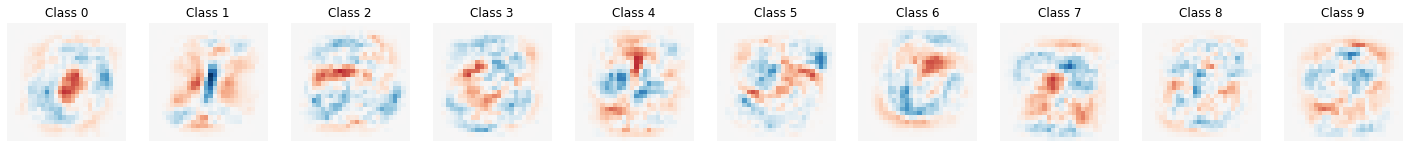

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 2.5));

for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('Class %i' % i);

We can see which pixels are positively associated with belonging to the class, and which pixels are negatively associated with belonging to the class.

For example, consider Class 0. If a sample has large values in the pixels shown in blue (the 0 shape around the center of the image), the probability of that sample being a 0 digit increases. If the sample has large values in the pixels in the center of the image, the probability of the sample being a 0 digit decreases.

Many pixels have coefficients whose magnitude are very small. These are shown in white, and they are not very important for this classification task.

### Use a fitted logistic regression

Given the coefficient matrix, we can get the per-class probability for any sample.

We know that for logistic regression with the softmax function, the conditional probability of a sample belonging to class $k$ is given by:

$$P(y=k | \mathbf{x}) = \frac{e^{z_k}}{\sum_{\ell=1}^K e^{z_\ell}}$$

where $z_{k} = w_k x$.

($w_k$ is the weight vector for class $k$, and $x$ includes a 1s column so that the intercept can be included in the weight matrix.)

As an example, let’s look at a specific test sample:

In [ ]:
sample_idx = 33

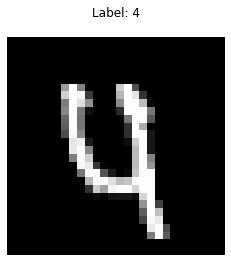

In [ ]:
plt.imshow(X_test_scaled[sample_idx].reshape(28,28), cmap='gray');
plt.title('Label: %s\n' % y_test[sample_idx]);
plt.axis('off');

We’l compute $z_k$ for each class $k$:

In [ ]:
z = [ clf.intercept_[k] + np.dot(clf.coef_[k], X_test_scaled[sample_idx]) for k in range(10) ]
z

[-2.8845893637405413,
 -4.3761383710076736,
 2.502246993601539,
 -0.282297404901287,
 2.533523469912377,
 -2.0534339236667503,
 -0.5840086166347845,
 2.187238094568292,
 -1.2206640666490545,
 4.1781231885179935]

Then, we can compute the conditional probability for each class, for this sample:

In [ ]:
exps = [np.exp(z[k]) for k in range(10)]
exps_sum = np.sum(exps)
probs = exps/exps_sum
probs

array([5.54534780e-04, 1.24783536e-04, 1.21171949e-01, 7.48324265e-03,
       1.25021670e-01, 1.27319525e-03, 5.53424414e-03, 8.84291536e-02,
       2.92794129e-03, 6.47479285e-01])

Here, the first entry is the probability of belonging to class 0 (i.e. having the label '0'), the second entry is the probability of belonging to class 1, etc.

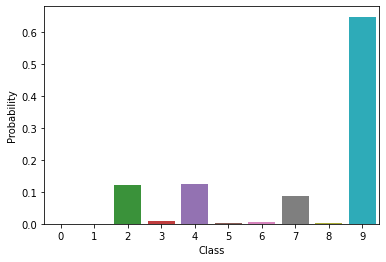

In [ ]:
sns.barplot(x=np.arange(0,10), y=probs);
plt.ylabel("Probability");
plt.xlabel("Class");

In general, to get the predicted *label*, we can find the class with the highest probability:

In [ ]:
idx_cls = np.argmax(probs)
classes[idx_cls]

'9'

*If* this matches the actual label for the first test sample, then our prediction is correct.

In [ ]:
y_test[sample_idx]

'4'

The `LogisticRegression` implementation in `sklearn` includes functions to compute both the per-class probability, and the most likely label.

We can use the `predict_proba` function on the logistic regression to get these probabilities. For each sample, it returns 10 probabilities - one for each of the ten classes (i.e. each value of $k$).

In [ ]:
y_pred_prob = clf.predict_proba(X_test_scaled)

Let’s look at our example test point, and compare to our own computations:

In [ ]:
y_pred_prob[sample_idx]

array([5.54534780e-04, 1.24783536e-04, 1.21171949e-01, 7.48324265e-03,
       1.25021670e-01, 1.27319525e-03, 5.53424414e-03, 8.84291536e-02,
       2.92794129e-03, 6.47479285e-01])

We use the `predict` function to predict a label for each sample in the test set. This will return the class label with the highest probability.

For our test sample, the prediction is:

In [ ]:
y_pred = clf.predict(X_test_scaled)

In [ ]:
y_pred[sample_idx]

'9'

and the true value is:

In [ ]:
y_test[sample_idx]

'4'

### Evaluate classifier performance

The first important metric is the accuracy - what percent of predicted labels are the same as the true labels?

There are a few ways to compute this value -

In [ ]:
accuracy =  np.mean(y_test == y_pred)
print(accuracy)

0.9084


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9084


In [ ]:
accuracy = clf.score(X_test_scaled, y_test)
print(accuracy)

0.9084


What about other important metrics?

For a binary classifier, we also care about

-   The number of true positive (TP) outputs - samples from the positive class that are predicted as positive
-   The number of true negative (TN) outputs - samples from the negative class that are predicted as negative
-   The number of false positive (FP) outputs - samples from the negative class that are predicted as positive, and
-   The number of false negative (FN) outputs - samples from the positive class that are predicted as negative.

These are often presented together in a confusion matrix.

For a multi-class problem, we can extend the confusion matrix to have more rows and columns. The diagonal of the multi-class confusion matrix shows the number of correct classifications for each class, and other entries show instances where a sample from one class was mistakenly assigned a different class label.

We can create a confusion matrix using the `pandas` library's `crosstab` function.

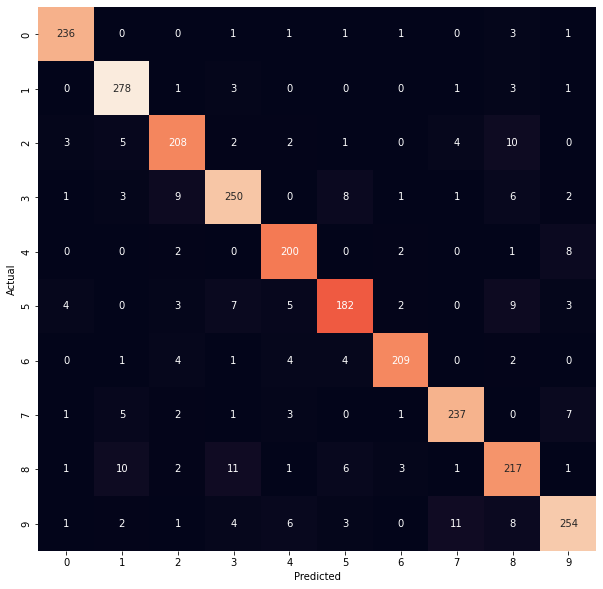

In [ ]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'])
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

Here's a version that is slightly easier to interpret - we have normalized the confusion matrix by row, so that the entries on the diagonal show the accuracy per class.

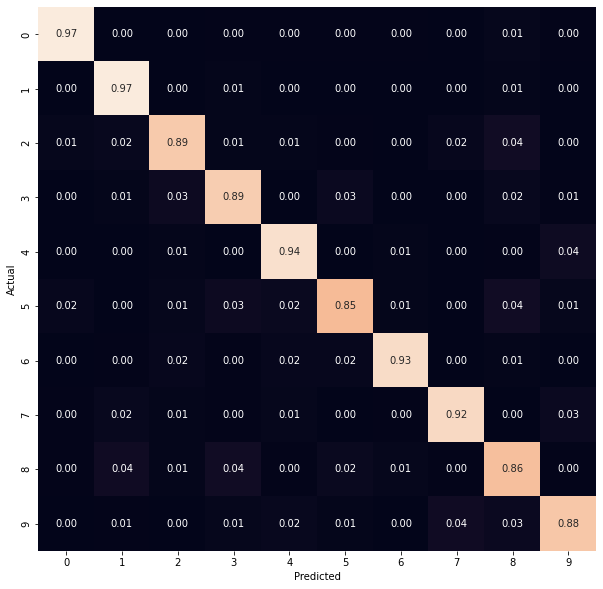

In [ ]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

We can see that the digits 0, 1, 4 are easiest for the logistic regression to classify, while the digits 8, 5, 2, and 3 are more difficult (because the classification accuracy was less for these digits).

We can also see which digits are easily confused with one another. For example, we can see that some 8s are misclassified as 1s, and some 5s are misclassified as 8s.

### Try your own image

On a plain white piece of paper, in a black or other dark-colored pen or pencil, write a digit of your choice from 0 to 9. Take a photo of your handwritten digit.

Edit your photo (crop, rotate as needed), using a photo editor of your choice (I used Google Photos), so that your photo is approximately square, and includes only the digit and the white background. Leave a small margin around the edge of the writing, but not too much. Your edited photo should look similar to the MNIST images in the demo notebook.

For example:

<img src="https://i.ibb.co/RzLP8nm/20200710-115731.jpg" alt="A handwritten '8'" width=200/>

Run the following cell. Click “Choose files”, and upload the photo of your handwritten digit.

In [ ]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sample6.jpg to sample6.jpg
User uploaded file "sample6.jpg" with length 118443 bytes


On the left side of the Colab window, you will see a small file folder icon, which allows you to explore the filesystem of your Colab workspace. If you click on this icon, you should see that your file has been uploaded to your Colab workspace. (You may need to use the “Refresh” button in the file browser in order to see the file.) Make a note of the file name.

After uploading your image, run this cell, but *replace the filename* with the name of the file you have just uploaded to Colab. You shold see your image appear in the cell output.

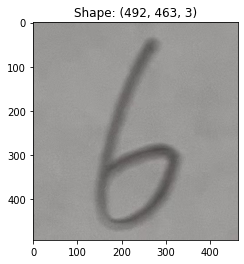

In [ ]:
from PIL import Image
 
filename = 'sample6.jpg'
 
image = Image.open(filename)
p = plt.imshow(np.asarray(image), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image).shape))

For example:

<img src="https://i.ibb.co/jy2Qt6Z/image.png" alt="A handwritten '8' after uploading to Colab" width=200/>

The images in MNIST have been pre-processed - they are converted to grayscale, and centered in a 28x28 image by computing the center of mass of the pixels, and then translating and scaling the image so as to position this point at the center of the 28x28 field.

You have already done some manual pre-processing, by cropping your image before uploading. But you may have noticed from the `shape` output that your image resolution is much larger than 28x28, and you probably had three color channels (red, green, and blue).

Use the code in the following cells to pre-process your image into a 28x28 image with one color channel (grayscale). You may have to manually tune the contrast for best results, by changing the `pixel_filter` value. You will want the background to be as close to pure black as possible, without affecting the legibility of the handwritten digit.

(We won’t bother with centering the image, but that would probably improve the prediction performance quite a lot!)

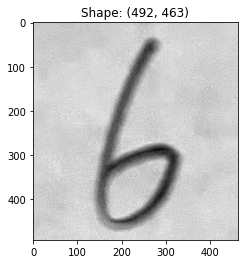

In [ ]:
# convert to grayscale image - 'L' format means each pixel is 
# represented by a single value from 0 to 255
image_bw = image.convert('L')
p = plt.imshow(np.asarray(image_bw), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw).shape))

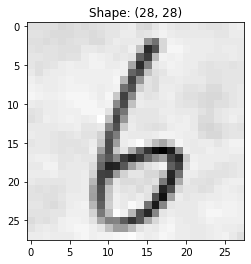

In [ ]:
# resize image 
image_bw_resized = image_bw.resize((28,28), Image.ANTIALIAS)
p = plt.imshow(np.asarray(image_bw_resized), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw_resized).shape))

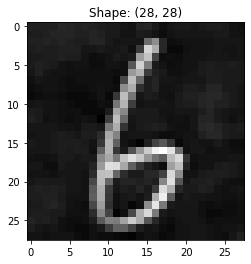

In [ ]:
# invert image, to match training data
import PIL.ImageOps    

image_bw_resized_inverted = PIL.ImageOps.invert(image_bw_resized)
p = plt.imshow(np.asarray(image_bw_resized_inverted), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw_resized_inverted).shape))

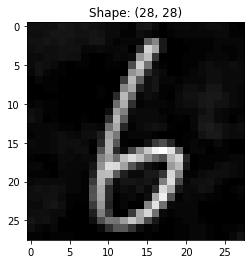

In [ ]:
# adjust contrast and scale
pixel_filter = 20 # value from 0 to 100 - may need to adjust this manually
min_pixel = np.percentile(image_bw_resized_inverted, pixel_filter)
image_bw_resized_inverted_scaled = np.clip(image_bw_resized_inverted-min_pixel, 0, 255)
max_pixel = np.max(image_bw_resized_inverted_scaled)
image_bw_resized_inverted_scaled = np.asarray(image_bw_resized_inverted_scaled)/max_pixel
p = plt.imshow(np.asarray(image_bw_resized_inverted_scaled), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(np.asarray(image_bw_resized_inverted_scaled).shape))

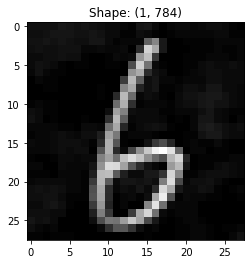

In [ ]:
# finally, reshape to (1, 784) - 1 sample, 784 features
test_sample = np.array(image_bw_resized_inverted_scaled).reshape(1,784)
p = plt.imshow(np.reshape(test_sample, (28,28)), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(test_sample.shape))

Make sure the `shape` of your test sample is `(1,784)` (one sample, 784 features).

Run the following code to visualize your pre-processed image.

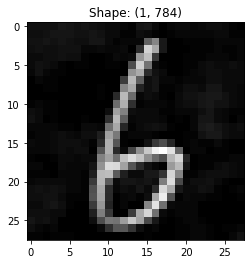

In [ ]:
p = plt.imshow(np.reshape(test_sample, (28,28)), cmap=plt.cm.gray,);
p = plt.title('Shape: ' + str(test_sample.shape))

For example:

<img src="https://i.ibb.co/0rD9Z75/image.png" alt="A handwritten '8' after pre-processing" width=200/>

Now that you have processed your test image, let us see whether it is classified correctly by the logistic regression.

Run the following cell. This will use your fitted logistic regression to predict conditional probabilities per class for this test sample, and plot them.

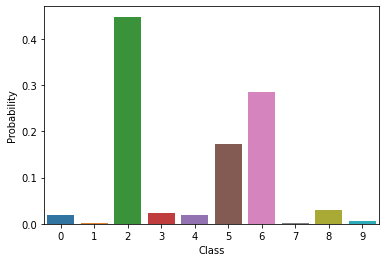

In [ ]:
test_probs = clf.predict_proba(test_sample)

sns.barplot(x=np.arange(0,10), y=test_probs.squeeze());
plt.ylabel("Probability");
plt.xlabel("Class");

For example:

<img src="https://i.ibb.co/80TzWQv/image.png" alt="Probabilities" />

Also run this cell, to show the predicted label for your test sample:

In [ ]:
test_pred = clf.predict(test_sample)
print("Predicted class is: ", test_pred)

Predicted class is:  ['2']


Even if the fitted model correctly labeled your handwritten digit, it may have estimated a moderately high probability for some of the other labels. To understand why, it is useful to visualize

$$\langle w_k, x\rangle$$

for each class $k$.

Add a cell with the following code, and run it. This will plot:

-   on the top row, the coefficient vector for each class,
-   on the bottom row, each pixel in your test image, multiplied by the associated coefficient for that class.

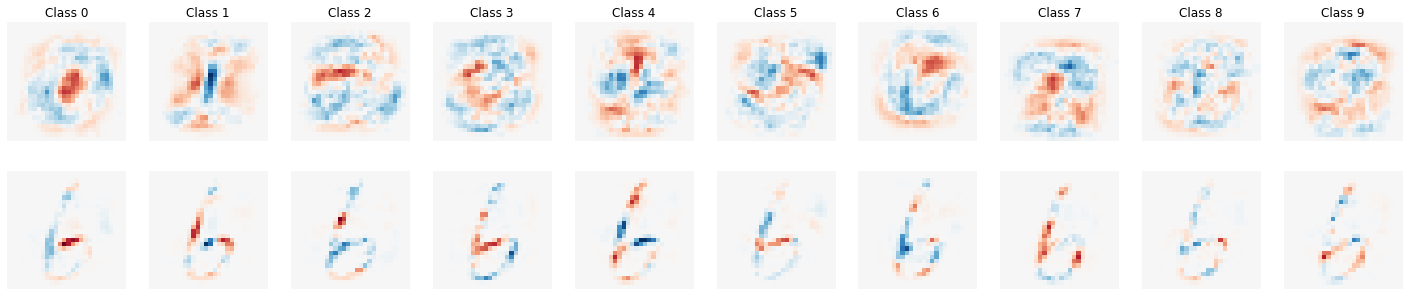

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 5));

for i in range(nclasses):
    p = plt.subplot(2, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.title('Class %i' % i);
    p = plt.axis('off')

for i in range(nclasses):
    p = plt.subplot(2, nclasses, nclasses + i + 1)
    p = plt.imshow(test_sample.reshape(28, 28)*clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale/2, vmax=scale/2);
    # note: you can adjust the scaling factor if necessary,
    # to make the visualization easier to understand
    p = plt.axis('off')

For example:

<img src="https://i.ibb.co/MGLkf0T/image.png" alt="A handwritten '8' after pre-processing"/>

In the images in the bottom row,

-   a blue pixel (and especially a dark blue pixel) means that your test image had writing in the part of the image that is positively associated with belonging to the class, and
-   a red pixel (and especially a dark red pixel) means that your test image had writing in the part of the image that is negatively associated with belonging to the class.

The image above should give you an idea of why your digit was classified correctly or incorrectly, and should help you understand when and why the model misclassifies some samples.

-   if your image *was* classified correctly: draw a *slightly* modified version of the same digit, that you believe will be classified *incorrectly*. Run this second image through the steps above, and confirm your intuition.
-   if your image *was not* classified correctly: draw a *slightly* modified version of the same digit, that you believe will be classified *correctly*. Run this second image through the steps above, and confirm your intuition.

(Your second image should still be approximately square, include only the digit and the white background, and have a small margin around the edge of the writing, i.e. it should also “look like” the MNIST samples.)

### Regularization

For the handwritten digit recognition task, many of the pixels (especially those near the outer border of the image) are not relevant. We can use L1 regularization to do feature selection, i.e. encourage a zero coefficient for features that are not relevant.

However, the classifier still fits a non-zero coefficient for those pixels. In the following images, any pixel with a zero coefficient is marked in black:

In [ ]:
zeros = np.ma.masked_where(clf.coef_ != 0, clf.coef_)

scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 3));

for i in range(nclasses):
    p = plt.subplot(2, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.imshow((zeros[i]).reshape(28, 28),
                  cmap=plt.cm.gray, vmin=0, vmax=1);
    p = plt.title('Class %i' % i);
    p = plt.axis('off')


L1 regularization will encourage more zero coefficients. To fit a logistic regression with regularization, we specify the penalty and the regularization strength.

The parameter `C` is actually the *inverse* of the regularization strength, so a small value means stronger regularization and more coefficients zeroed.

In [ ]:
clf_l1 = LogisticRegression(penalty='l1', C=1,
                      tol=0.1, solver='saga',
                      multi_class='multinomial').fit(X_train_scaled, y_train)

The coefficients for the regularized model are shown in the bottom row below.

With the L1 penalty, many more coefficients are zeroed.

In [ ]:

zeros = np.ma.masked_where(clf.coef_ != 0, clf.coef_)
zeros_l1 = np.ma.masked_where(clf_l1.coef_ != 0, clf.coef_)

scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 5));

for i in range(nclasses):
    p = plt.subplot(2, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.imshow((zeros[i]).reshape(28, 28),
                  cmap=plt.cm.gray, vmin=0, vmax=1);
    p = plt.title('Class %i' % i);
    p = plt.axis('off')

for i in range(nclasses):
    p = plt.subplot(2, nclasses, nclasses + i + 1)
    p = plt.imshow(clf_l1.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.imshow((zeros_l1[i]).reshape(28, 28),
                  cmap=plt.cm.gray, vmin=0, vmax=1);
    p = plt.title('Class %i' % i);
    p = plt.axis('off')

Things to try:

-   What happens if you increase C? decrease C?